# Neural Networks for Binary Classification: Diabetes Diagnosis

## My Info 
Name : Hamza Ahmed 
Id : 1210219


In [1]:
# Set random seeds for reproducible results
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# Data processing and visualization
import numpy as np                           # Numerical computing
import pandas as pd                          # Data manipulation
from sklearn.model_selection import train_test_split  # Split data into train/test
from sklearn.preprocessing import StandardScaler    # Scale features (normalize values)
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score  # Evaluation metrics

# Deep learning
from tensorflow.keras import models, layers  # Build neural network
from tensorflow.keras.optimizers import Adam  # Optimizer for training
from tensorflow.keras.callbacks import EarlyStopping  # Stop training when validation loss plateaus

# Visualization
import matplotlib.pyplot as plt              # Plot training curves and results
import seaborn as sns                        # Enhanced visualizations

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## 1. Load Pima Indians Diabetes Dataset

**Source**: UCI Machine Learning Repository / Kaggle (local CSV)  
**Samples**: 768 patients  
**Features**: 8 clinical measurements (pregnancies, glucose, BP, skin thickness, insulin, BMI, pedigree, age)  
**Classes**: Diabetes (0=No, 1=Yes)  
**Challenge**: ~70-75% max accuracy (realistic problem)

In [2]:
# Load the Pima Indians Diabetes dataset from local CSV file
print("Loading Pima Indians Diabetes dataset from local file...")
data = pd.read_csv('diabetes.csv')

# Handle missing/zero values in columns where 0 is not valid
# Columns like Glucose, BloodPressure, SkinThickness, Insulin, BMI cannot be 0
zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in zero_columns:
    data[col] = data[col].replace(0, np.nan)
    data[col] = data[col].fillna(data[col].median())

print(f"Dataset loaded successfully!")
print(f"Total samples: {data.shape[0]}")

# Extract features (X) and labels (y)
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
X = data[feature_names].values
y = data['Outcome'].values

target_names = np.array(['No Diabetes', 'Diabetes'])

print(f"\nFeatures shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Feature names: {list(feature_names)}")
print(f"Target classes: {target_names}")

Loading Pima Indians Diabetes dataset from local file...
Dataset loaded successfully!
Total samples: 768

Features shape: (768, 8)
Labels shape: (768,)
Feature names: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Target classes: ['No Diabetes' 'Diabetes']


In [3]:
# Explore the dataset structure
print("=" * 70)
print("PIMA INDIANS DIABETES DATASET EXPLORATION")
print("=" * 70)

print(f"\nTotal samples: {X.shape[0]}")
print(f"Total features: {X.shape[1]}")

print(f"\nFeatures represent clinical measurements:")
print(f"  • Pregnancies (number of times pregnant)")
print(f"  • Glucose (plasma glucose concentration, 2h OGTT)")
print(f"  • BloodPressure (diastolic blood pressure, mmHg)")
print(f"  • SkinThickness (triceps skinfold thickness, mm)")
print(f"  • Insulin (2-hour serum insulin, mu U/ml)")
print(f"  • BMI (body mass index, kg/m²)")
print(f"  • DiabetesPedigreeFunction (genetic risk score)")
print(f"  • Age (years)")

print(f"\nClass Distribution:")
print(f"  No Diabetes (0): {np.sum(y == 0)} samples ({100*np.sum(y==0)/len(y):.1f}%)")
print(f"  Diabetes (1): {np.sum(y == 1)} samples ({100*np.sum(y==1)/len(y):.1f}%)")

print(f"\nFeature Value Ranges (varies by measurement type):")
print(f"  Min values: {X.min(axis=0)[:5]}")
print(f"  Max values: {X.max(axis=0)[:5]}")
print(f"  Note: Features have very different scales → MUST normalize!")

print(f"\nFirst 5 patients (first 5 features):")
print(f"  Pregnancies | Glucose | BloodPressure | SkinThickness | Insulin")
for i in range(5):
    print(f"       {X[i, 0]:.0f}      |  {X[i, 1]:.0f}   |      {X[i, 2]:.0f}       |       {X[i, 3]:.0f}       |   {X[i, 4]:.0f}")

PIMA INDIANS DIABETES DATASET EXPLORATION

Total samples: 768
Total features: 8

Features represent clinical measurements:
  • Pregnancies (number of times pregnant)
  • Glucose (plasma glucose concentration, 2h OGTT)
  • BloodPressure (diastolic blood pressure, mmHg)
  • SkinThickness (triceps skinfold thickness, mm)
  • Insulin (2-hour serum insulin, mu U/ml)
  • BMI (body mass index, kg/m²)
  • DiabetesPedigreeFunction (genetic risk score)
  • Age (years)

Class Distribution:
  No Diabetes (0): 500 samples (65.1%)
  Diabetes (1): 268 samples (34.9%)

Feature Value Ranges (varies by measurement type):
  Min values: [ 0. 44. 24.  7. 14.]
  Max values: [ 17. 199. 122.  99. 846.]
  Note: Features have very different scales → MUST normalize!

First 5 patients (first 5 features):
  Pregnancies | Glucose | BloodPressure | SkinThickness | Insulin
       6      |  148   |      72       |       35       |   125
       1      |  85   |      66       |       29       |   125
       8      |  18

## 2. Data Preprocessing

**Steps**:
1. Split data: 80% training, 20% testing
2. Scale features to mean=0, std=1 (StandardScaler)
3. Fit scaler only on training data (prevent data leakage)

In [4]:
# Step 1: Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,           # 20% for testing
    random_state=42,         # For reproducibility
    stratify=y               # Keep class distribution in both sets
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(f"  No Diabetes: {np.sum(y_train == 0)} ({100*np.sum(y_train==0)/len(y_train):.1f}%)")
print(f"  Diabetes: {np.sum(y_train == 1)} ({100*np.sum(y_train==1)/len(y_train):.1f}%)")

print(f"\nBefore Scaling - Feature Statistics:")
print(f"  Mean: {X_train.mean(axis=0)[:3]}")
print(f"  Std Dev: {X_train.std(axis=0)[:3]}")

Training set size: 614 samples
Testing set size: 154 samples

Training set class distribution:
  No Diabetes: 400 (65.1%)
  Diabetes: 214 (34.9%)

Before Scaling - Feature Statistics:
  Mean: [  3.81921824 121.67100977  72.14006515]
  Std Dev: [ 3.31144822 29.97935076 12.26511926]


In [5]:
# Step 2: Scale features using StandardScaler
scaler = StandardScaler()

# Fit on training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data using training statistics (DO NOT refit!)
X_test_scaled = scaler.transform(X_test)

print("After Scaling - Feature Statistics:")
print(f"  Training mean: {X_train_scaled.mean(axis=0)[:3]} (should be ~0)")
print(f"  Training std dev: {X_train_scaled.std(axis=0)[:3]} (should be ~1)")
print(f"  Test mean: {X_test_scaled.mean(axis=0)[:3]} (close to 0)")
print(f"  Test std dev: {X_test_scaled.std(axis=0)[:3]} (close to 1)")

print(f"\n✓ Data preprocessing complete!")

After Scaling - Feature Statistics:
  Training mean: [-1.87146715e-17 -8.02832285e-17  3.23302731e-16] (should be ~0)
  Training std dev: [1. 1. 1.] (should be ~1)
  Test mean: [ 0.03890555 -0.00245526  0.10028967] (close to 0)
  Test std dev: [1.08105932 1.07105375 0.92172508] (close to 1)

✓ Data preprocessing complete!


## 3. Build Neural Network

**Architecture**: Input(8) → Dense(32, ReLU) → Dense(16, ReLU) → Output(1, Sigmoid)

**Key Points**:
- ReLU adds non-linearity to learn complex patterns
- Sigmoid outputs probability (0-1) for binary classification
- Moderate data (768 samples) → watch for overfitting

In [6]:
# Build the neural network model using Sequential API
model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(8,)),    # Input: 8 features
    layers.Dense(16, activation='relu'),                        # Hidden layer 2
    layers.Dense(1, activation='sigmoid')                       # Output: probability
])

# Display model architecture
print("Model Architecture:")
model.summary()
print("\n📌 Note: With 768 samples, watch for overfitting!")
print("   Training accuracy >> Validation accuracy = sign of overfitting")

c:\Users\hamza\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 833 (3.25 KB)

 Trainable params: 833 (3.25 KB)

 Non-trainable params: 0 (0.00 B)


📌 Note: With 768 samples, watch for overfitting!
   Training accuracy >> Validation accuracy = sign of overfitting


## 4. Compile Model

**Configuration**:
- **Optimizer**: Adam (adaptive learning rate)
- **Loss**: Binary crossentropy (for binary classification)
- **Metric**: Binary accuracy

In [7]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),        # Adaptive optimizer
    loss='binary_crossentropy',                 # For binary classification
    metrics=['binary_accuracy']                 # Track accuracy during training
)

print("✓ Model compiled successfully!")

✓ Model compiled successfully!


## 5. Train Model with Early Stopping

**Parameters**: Max 100 epochs, batch size 32, 20% validation split  
**Early Stopping**: Stop if validation loss doesn't improve for 5 epochs (aggressive to catch overfitting early)  
**Note**: If training/validation accuracy gap is large, consider adding `Dropout(0.3)` layers or reducing neuron counts

In [8]:
# Set up Early Stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',                      # Watch validation loss
    patience=5,                              # Stop if no improvement for 5 epochs (aggressive)
    restore_best_weights=True,               # Return to best weights
    verbose=1
)

# Train the model with Early Stopping
print("Starting training with Early Stopping...")
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,                              # Max epochs (may stop early)
    batch_size=32,                           # Samples per gradient update
    validation_split=0.2,                    # Use 20% of training data for validation
    callbacks=[early_stop],                  # Apply early stopping
    verbose=1                                # Show progress bar
)

print("\n✓ Training complete! Model stopped at best validation performance.")

Starting training with Early Stopping...
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - binary_accuracy: 0.6253 - loss: 0.6485 - val_binary_accuracy: 0.6829 - val_loss: 0.6122
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.6782 - loss: 0.6015 - val_binary_accuracy: 0.6911 - val_loss: 0.5822
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.6986 - loss: 0.5691 - val_binary_accuracy: 0.7236 - val_loss: 0.5582
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.7210 - loss: 0.5430 - val_binary_accuracy: 0.7317 - val_loss: 0.5377
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.7373 - loss: 0.5209 - val_binary_accuracy: 0.7317 - val_loss: 0.5214
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.7393 - loss: 0.5029 - val_binary_accuracy: 0.7561 - val_loss: 0.5079
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.7515 - loss: 0.4884 - val_binary_accurac

### Training Curves

Left: Accuracy over epochs | Right: Loss over epochs  
**Ideal**: Both curves plateau together (good generalization)

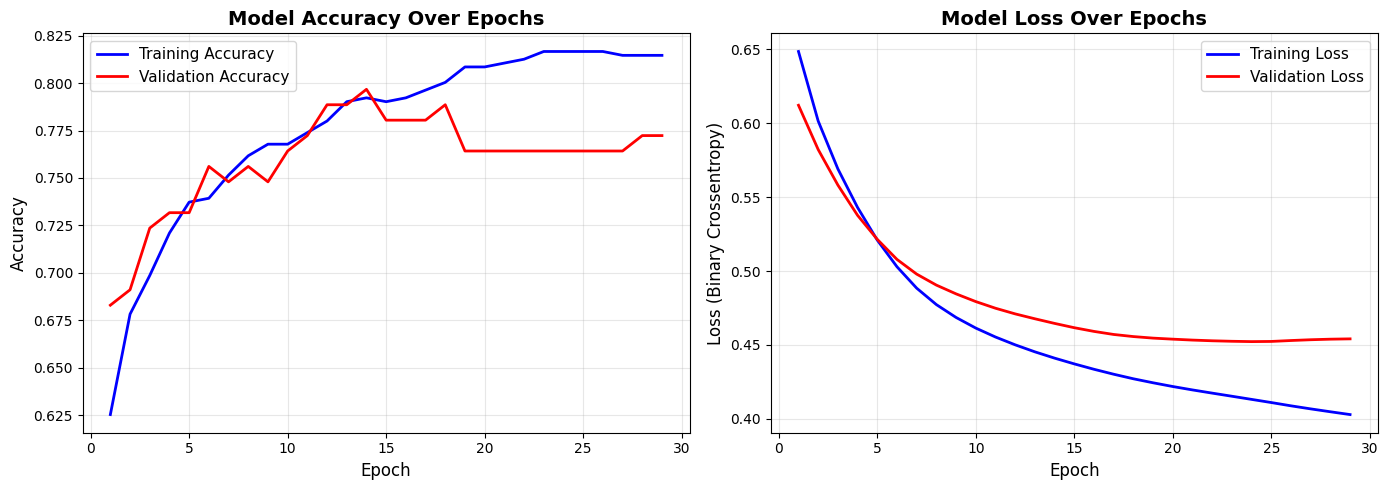

✓ Training visualization complete!


In [9]:
# Extract history data
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
accuracy_values = history.history['binary_accuracy']
val_accuracy_values = history.history['val_binary_accuracy']

epochs = range(1, len(loss_values) + 1)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy
ax1.plot(epochs, accuracy_values, 'b-', label='Training Accuracy', linewidth=2)
ax1.plot(epochs, val_accuracy_values, 'r-', label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Loss
ax2.plot(epochs, loss_values, 'b-', label='Training Loss', linewidth=2)
ax2.plot(epochs, val_loss_values, 'r-', label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss (Binary Crossentropy)', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Training visualization complete!")

## 6. Evaluate Model

**Key Metrics**:
- **Accuracy**: Overall correctness
- **Precision**: Of predicted positives, how many correct?
- **Recall**: Of actual positives, how many did we catch?
- **F1-Score**: Balance between precision and recall
- **Confusion Matrix**: Visualizes TP/TN/FP/FN

**Medical Note**: False negatives (missing diabetes diagnosis) are worse than false positives

In [10]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)

print("=" * 70)
print("MODEL EVALUATION ON TEST DATA")
print("=" * 70)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("\n✓ Model successfully evaluated on unseen test data!")

MODEL EVALUATION ON TEST DATA

Test Loss: 0.4930
Test Accuracy: 0.7338 (73.38%)

✓ Model successfully evaluated on unseen test data!


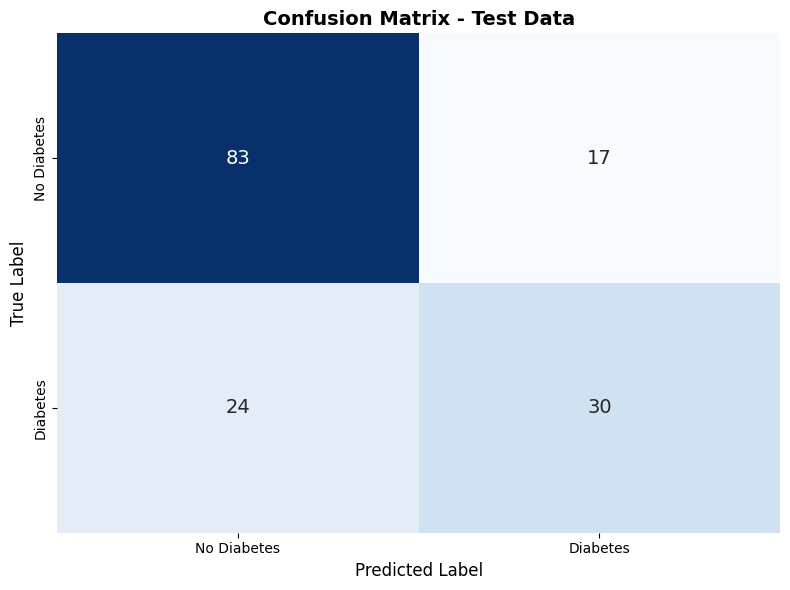


Confusion Matrix:
  True Negatives (TN):  83  (Correctly identified no diabetes)
  False Positives (FP): 17  (Incorrectly labeled diabetes)
  False Negatives (FN): 24  (Missed diabetes diagnosis)
  True Positives (TP):  30  (Correctly identified diabetes)


In [11]:
# Make predictions on test data
y_pred_prob = model.predict(X_test_scaled, verbose=0)  # Get probabilities
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert to class labels (0 or 1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'],
            annot_kws={'size': 14})
plt.title('Confusion Matrix - Test Data', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix:")
print(f"  True Negatives (TN):  {cm[0, 0]}  (Correctly identified no diabetes)")
print(f"  False Positives (FP): {cm[0, 1]}  (Incorrectly labeled diabetes)")
print(f"  False Negatives (FN): {cm[1, 0]}  (Missed diabetes diagnosis)")
print(f"  True Positives (TP):  {cm[1, 1]}  (Correctly identified diabetes)")

In [12]:
# Calculate additional metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculate metrics for each class
precision_no_diabetes = precision_score(y_test, y_pred, pos_label=0)
recall_no_diabetes = recall_score(y_test, y_pred, pos_label=0)

print("=" * 70)
print("DETAILED CLASSIFICATION METRICS")
print("=" * 70)

print(f"\nOverall Metrics:")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  Precision: {precision:.4f} (of predicted diabetes, {precision*100:.2f}% are correct)")
print(f"  Recall:    {recall:.4f} (we catch {recall*100:.2f}% of actual diabetes cases)")
print(f"  F1-Score:  {f1:.4f} (harmonic mean)")

print(f"\nNo Diabetes (Class 0) Identification:")
print(f"  Recall:    {recall_no_diabetes:.4f} (catch {recall_no_diabetes*100:.2f}% of non-diabetic cases)")
print(f"  Precision: {precision_no_diabetes:.4f}")

print(f"\n📊 Medical Interpretation:")
print(f"  • False Negatives: {cm[1, 0]} cases (predicted no diabetes but actually diabetic) ⚠️")
print(f"  • False Positives: {cm[0, 1]} cases (predicted diabetes but actually non-diabetic)")
print(f"  • For medical diagnosis: Recall (catching diabetes) is critical!")

DETAILED CLASSIFICATION METRICS

Overall Metrics:
  Accuracy:  0.7338
  Precision: 0.6383 (of predicted diabetes, 63.83% are correct)
  Recall:    0.5556 (we catch 55.56% of actual diabetes cases)
  F1-Score:  0.5941 (harmonic mean)

No Diabetes (Class 0) Identification:
  Recall:    0.8300 (catch 83.00% of non-diabetic cases)
  Precision: 0.7757

📊 Medical Interpretation:
  • False Negatives: 24 cases (predicted no diabetes but actually diabetic) ⚠️
  • False Positives: 17 cases (predicted diabetes but actually non-diabetic)
  • For medical diagnosis: Recall (catching diabetes) is critical!
